In [0]:
#############################################################

# Vocabulary




In [0]:
import numpy as np
import keras
from keras import Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, LSTM, Activation, Dense, Input, Dropout
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:

new_features =[
"inicio del contrato",
"fin del contrato",
"encabezado",
"obligaciones",
"lorem ipsum"
]

In [0]:
vocabulario = {}
vocabulario_inverso = {}

for id, i in enumerate(new_features):
  value = i.lower()
  vocabulario[value]=id
  vocabulario_inverso[id]=value
  print(value)
  

##Sanity check of encoding maps

In [0]:
vocabulario["obligaciones"]

# Cargar Ejemplos

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
! cp [some_path]/dataset_dev_PS-CV-1.0.0.txt dev.txt .
! cp [some_path]/dataset_train_PS-CV-1.0.0.txt train.txt .

In [0]:
! cat train.txt

In [0]:
import os
import json

fileName = "train.txt"
train = []
if os.path.isfile(fileName):
   with open(fileName, 'r') as infile:
      train = json.load(infile)
      
fileName = "dev.txt"
dev = []
if os.path.isfile(fileName):
   with open(fileName, 'r') as infile:
      dev = json.load(infile)


#Encoding helpers


In [0]:
def features_to_hot_encoding(contrato):
  n_clausulas = len(contrato)
  palabras = len(vocabulario)
  hot_encoded = np.zeros((n_clausulas,palabras))
  cont = 0
  keys = vocabulario.keys()
  for i in contrato:
    encode = np.zeros((palabras))
    for j in i:
      if j in keys:
        index = vocabulario[j]
        encode[index] = 1
    if(len(np.nonzero(encode)[0]) == 0 and len(i) > 0):
      pass
    else:
      hot_encoded[cont] = encode
      cont += 1
    
  while cont < n_clausulas:
    hot_encoded[cont] = np.zeros((palabras))
    cont += 1
  return hot_encoded

In [0]:
def stack_matrix_first_axis(m1, m2):
    assert m1.shape[1] == m2.shape[0], "Shape must be equal and was " + str(m1.shape[1]) + " and " + str(m2.shape[1]) 
    assert m1.shape[2] == m2.shape[1], "Shape must be equal and was " + str(m1.shape[1]) + " and " + str(m2.shape[1])
    return np.append(m1,np.array([m2]),axis=0)

In [0]:
def check_not_end(contrs):
  for i in contrs:
    for f in i:
      for j in f:
        if j == "fin del contrato": 
          return False
  return True

In [0]:
def check_max_length(contratos):
  max=0
  for i in contratos:
    if(len(i) > max):
      max = len(i)
      
  return max

#ENCODING FUNCTION

In [0]:
import copy

# Returns X and Y embebbing representation of a given contract.
# Input: A list that contains contracts, described by a list of different feature vectors of our vocabulary.
# Output: 
#        x,y matrix of encoded representation.
def contracts_to_embbebing(contrs_clean):
  
  contrs = contrs_clean
  
  assert len(contrs) != 0, "Length must be different to zero"
  assert isinstance(contrs[0], list), "Contracts must be a list"
  assert isinstance(contrs[0][0][0], str) and len(contrs[0][0][0]) > 1, "Clauses must be strings"
  assert check_not_end(contrs), "Contracts can not have end"
  
  contrs = copy.deepcopy(contrs_clean)
  
  maxlength = check_max_length(contrs)
  
  # to add the end
  maxlength = maxlength +1 
   
  # add fin and verify the size  
  for contr in contrs:
    contr.append(["fin del contrato"])
    while len(contr) < maxlength:
      contr.append([])
  
       
  m = len(contrs)
  
  #Creating X and Y 
  
  x = features_to_hot_encoding(contrs[0][:maxlength-1])
  
  x = np.expand_dims(x,axis=0)
  
  y = features_to_hot_encoding(contrs[0][1:maxlength])
  
  y = np.expand_dims(y,axis=0)

  
  for i in contrs[1:]:
    x = stack_matrix_first_axis(x,features_to_hot_encoding(i[:maxlength-1]))
    y = stack_matrix_first_axis(y,features_to_hot_encoding(i[1:maxlength]))
    
  return x,y
  

##CREATE ENCONDING

In [0]:
x_train,y_train = contracts_to_embbebing(train)
x_dev,y_dev = contracts_to_embbebing(dev)

In [0]:
x_train.shape

#CREATE MODEL



In [0]:
def modelo(vocab_size):
  model = Sequential()
  model.add(LSTM(18, input_shape=(None,vocab_size), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(16, input_shape=(None,vocab_size), return_sequences=True))
  model.add(Dropout(0.4))
  model.add(Dense((vocab_size)))
  model.add(Activation('sigmoid'))
  optimizer = RMSprop(lr=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  return model

In [0]:
vocab_size = len(vocabulario)
model = modelo(vocab_size)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 3)           480       
_________________________________________________________________
dense_3 (Dense)              (None, None, 36)          144       
_________________________________________________________________
activation_4 (Activation)    (None, None, 36)          0         
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________
None


##Fit

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_dev,y_dev), epochs=900, verbose=1)

Train on 20 samples, validate on 4 samples
Epoch 1/900
20/20 [==============================] - 1s 53ms/step - loss: 0.6936 - acc: 0.4972 - val_loss: 0.6745 - val_acc: 0.8701
Epoch 2/900
20/20 [==============================] - 0s 879us/step - loss: 0.6748 - acc: 0.8740 - val_loss: 0.6578 - val_acc: 0.8905
Epoch 3/900
20/20 [==============================] - 0s 695us/step - loss: 0.6580 - acc: 0.9012 - val_loss: 0.6389 - val_acc: 0.8848
Epoch 4/900
20/20 [==============================] - 0s 712us/step - loss: 0.6389 - acc: 0.8963 - val_loss: 0.6175 - val_acc: 0.8811
Epoch 5/900
20/20 [==============================] - 0s 652us/step - loss: 0.6173 - acc: 0.8876 - val_loss: 0.5958 - val_acc: 0.8864
Epoch 6/900
20/20 [==============================] - 0s 617us/step - loss: 0.5950 - acc: 0.8884 - val_loss: 0.5753 - val_acc: 0.9056
Epoch 7/900
20/20 [==============================] - 0s 642us/step - loss: 0.5740 - acc: 0.9075 - val_loss: 0.5558 - val_acc: 0.9391
Epoch 8/900
20/20 [========

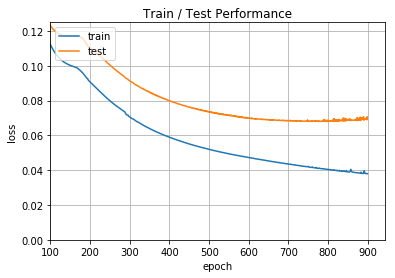

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train / Test Performance')
access = plt.gca()
access.set_xlim(100)
access.set_ylim(0,0.125)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

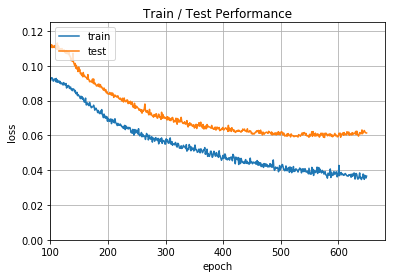

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train / Test Performance')
access = plt.gca()
access.set_xlim(100)
access.set_ylim(0,0.125)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

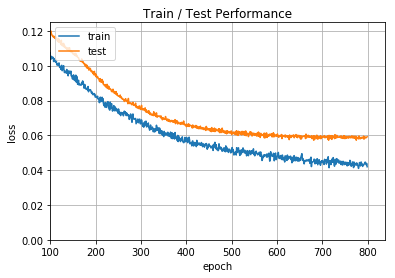

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train / Test Performance')
access = plt.gca()
access.set_xlim(100)
access.set_ylim(0,0.125)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#**Save model to disk**

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
! ls -lt

##Download model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
! cp model.h5 model.json [some_path]/model/version4

#**Debug model**

In [0]:
test, tesy = contracts_to_embbebing([contracts[0][0:-1]])

In [0]:
#print(X_test[:,0])
#print(X_test[:,1])
#print(X)
pred = model.predict(eso)[:,6]
print(pred)

idx = (-pred).argsort()[:,:6]
print(idx[0])
for i in idx[0]:
  print(vocabulario_inverso[i], end=" -> ")
  num = pred[0,i]*100
  print(num, end="")
  print("%")


----------------------------------------------------------